# **Clustering menggunakan Algoritma K-Means**

Pada clustering metode yang digunakan menggunakan K-Means. Algoritma ini umumnya bekerja sebagai berikut :


* Menentukan k sebagai jumlah cluster yang akan dibentuk
* Bangkitkan k centriod secara random
* Menghitung jarak setiap data ke centroid terdekat
* Tentukan cluster terdekat untk setiap data dengan membandingkan nilai jarak terdekat, lalu perbaharui nilai pusat clusternya.
* Ulangi sampai konvergen


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
import numpy as np 
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/salju") 

fileNames = os.listdir()
print(fileNames)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['salju_test.csv', 'salju_train.csv', 'Readme.txt', 'Salju_baru.csv']


In [ ]:
data = pd.read_csv("salju_train.csv") 
data.head(4)

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.4,15.5,4.8,NaN,NaN,WSW,24.0,NaN,WSW,0.0,13.0,78.0,76.0,1020.1,1018.5,NaN,NaN,13.1,15.0,Ya,Tidak
1,2,15/07/2014,C10,9.0,17.0,8.0,2.6,7.4,NaN,NaN,SW,WNW,13.0,20.0,80.0,61.0,1015.2,1014.6,7.0,5.0,11.9,15.5,Ya,Ya
2,3,16/02/2011,C46,18.2,32.0,0.0,NaN,NaN,ESE,44.0,SE,SE,15.0,26.0,62.0,42.0,NaN,NaN,NaN,NaN,23.8,29.6,Tidak,Tidak
3,4,08/08/2012,C36,7.3,24.5,0.0,8.4,10.4,SSW,54.0,N,SW,13.0,19.0,25.0,17.0,1019.2,1016.9,1.0,7.0,15.3,23.2,Tidak,Tidak


# Data Exploration

In [ ]:
data.dtypes

id                            int64
Tanggal                      object
KodeLokasi                   object
SuhuMin                     float64
SuhuMax                     float64
Hujan                       float64
Penguapan                   float64
SinarMatahari               float64
ArahAnginTerkencang          object
KecepatanAnginTerkencang    float64
ArahAngin9am                 object
ArahAngin3pm                 object
KecepatanAngin9am           float64
KecepatanAngin3pm           float64
Kelembaban9am               float64
Kelembaban3pm               float64
Tekanan9am                  float64
Tekanan3pm                  float64
Awan9am                     float64
Awan3pm                     float64
Suhu9am                     float64
Suhu3pm                     float64
BersaljuHariIni              object
BersaljuBesok                object
dtype: object

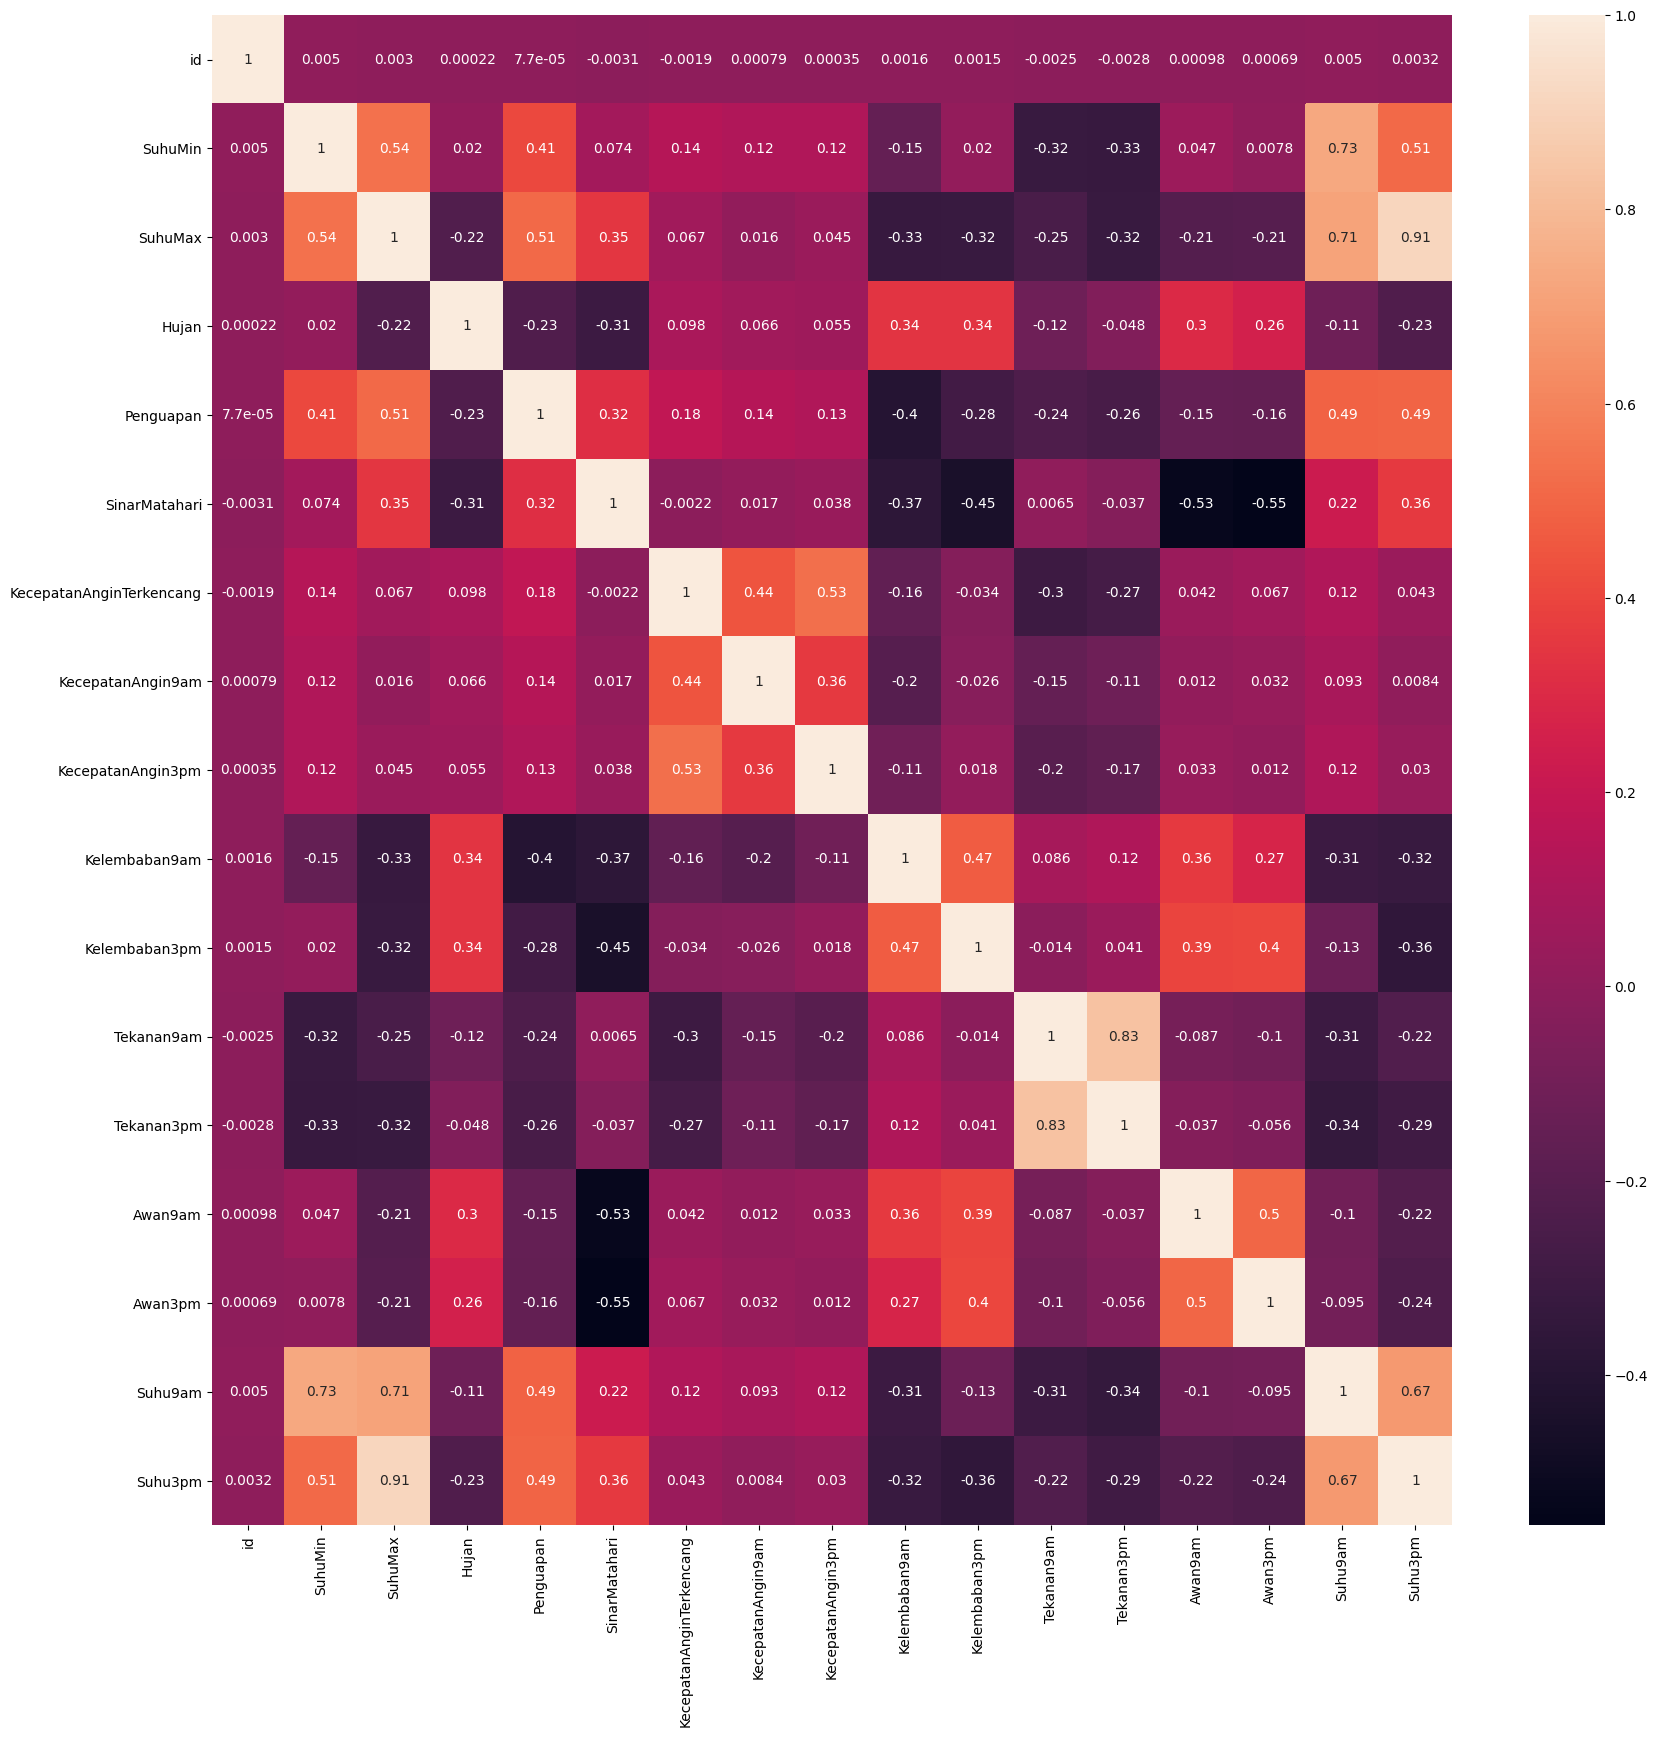

In [ ]:
# Korelasi antar atribut

import seaborn as sns

plt.figure(figsize=(20,20))
cor = data.corr(method="kendall")
sns.heatmap(cor, annot=True)
plt.show()

Merupakan hubungan antar atribut, yang memiliki korelasi yang tinggi adalah atribut yang nilainya mendekati 1

In [ ]:
#memilih kolom yang akan digunakan / feature selection

selected_col = ['SuhuMin','SuhuMax','Hujan','Penguapan']
data_baru = data[selected_col]
data_baru.to_csv('Salju_baru.csv')
data_baru

,SuhuMin,SuhuMax,Hujan,Penguapan
0,10.4,15.5,4.8,NaN
1,9.0,17.0,8.0,2.6
2,18.2,32.0,0.0,NaN
3,7.3,24.5,0.0,8.4
4,5.9,20.3,0.0,3.6
...,...,...,...,...
109090,20.1,23.7,0.0,7.2
109091,15.7,25.2,0.0,NaN
109092,7.5,20.4,1.6,NaN
109093,10.8,29.8,0.0,7.8


In [ ]:
#Menghilangkan duplikat data

dups = data_baru.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data_baru.loc[[11,28]]

Number of duplicate rows = 9372


,SuhuMin,SuhuMax,Hujan,Penguapan
11,-2.6,11.1,0.2,1.4
28,7.5,15.2,7.4,2.2


In [ ]:
print('Number of rows before discarding duplicates = %d' % (data_baru.shape[0]))
data = data_baru.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data.shape[0]))

Number of rows before discarding duplicates = 109095
Number of rows after discarding duplicates = 99723


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SuhuMin,99238.0,12.302225,6.471690,-8.5,7.7,12.1,17.1,33.9
SuhuMax,99375.0,23.208622,7.235236,-4.8,17.8,22.6,28.4,47.3
Hujan,97859.0,2.597516,8.935147,0.0,0.0,0.0,1.0,371.0
Penguapan,61121.0,5.470956,4.220986,0.0,2.6,4.8,7.4,145.0


# Data Pra-Process

## Missing Value

In [ ]:
#cek missing value

total=data.isnull().sum().sort_values(ascending = False)
print(total)

Penguapan    38602
Hujan         1864
SuhuMin        485
SuhuMax        348
dtype: int64


In [ ]:
#remove data null

data_baru = data.dropna(how='any',subset=['Penguapan','Hujan','SuhuMin','SuhuMax'])
data_baru.isnull().sum()

SuhuMin      0
SuhuMax      0
Hujan        0
Penguapan    0
dtype: int64

**Atau bisa mengisi missing value dengan nilai mean atau median**.

Sebelum mengisi nilai missing value, dicek terlebih dahulu skewness dari data, untuk menentukan teknik pengisian missing value yang tepat. Nilai skewness normal berada pada kisaran -2 sampai 2,jika nilai skewness normal maka data null diisi dengan mean. sedangkan jika tidak normal diisi dengan median.

In [ ]:
df=['SuhuMin','SuhuMax','Hujan','Penguapan']
data[df].skew(axis=0, skipna=True)

SuhuMin      0.002305
SuhuMax      0.217030
Hujan        9.666336
Penguapan    3.916651
dtype: float64

In [ ]:
#Mengisi missing value dengan mean dan median

data['SuhuMin'].fillna(data['SuhuMin'].mean(),inplace=True)
data['SuhuMax'].fillna(data['SuhuMax'].mean(),inplace=True)
data['Hujan'].fillna(data['Hujan'].median(),inplace=True)
data['Penguapan'].fillna(data['Penguapan'].median(),inplace=True)

In [ ]:
#Checking Missing Value

total=data.isnull().sum().sort_values(ascending = False)
print(total)

Penguapan    0
Hujan        0
SuhuMax      0
SuhuMin      0
dtype: int64


## Outlier

<Figure size 500x1500 with 0 Axes>

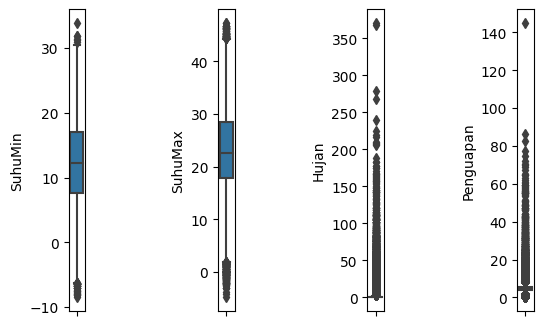

In [ ]:
mpl.rcParams['figure.dpi'] = 100
plt.figure(figsize=(5,15))
f, axes = plt.subplots(1, 4)
sns.boxplot(y=data["SuhuMin"], ax=axes[0])
sns.boxplot(y=data["SuhuMax"], ax=axes[1])
sns.boxplot(y=data["Hujan"], ax=axes[2])
sns.boxplot(y=data["Penguapan"], ax=axes[3])

plt.subplots_adjust(wspace=8)

In [ ]:
#membuat fungsi deteksi outlier univariat

def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3-Q1
 lower_range = Q1-(1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [ ]:
lowerbound,upperbound = outlier_treatment(data['SuhuMin'])
data[(data['SuhuMin'] < lowerbound) | (data['SuhuMin'] > upperbound)].index

Int64Index([ 10456,  11208,  12033,  15600,  15930,  18071,  18542,  23853,
             27788,  31190,  33849,  34112,  34330,  34493,  38888,  43728,
             47184,  47364,  49308,  52224,  56711,  62255,  62310,  65179,
             65797,  65921,  69599,  69680,  70405,  71964,  72618,  76105,
             83204,  88568,  89796,  92374,  92942,  94827,  97587, 100065,
            102979, 107071],
           dtype='int64')

In [ ]:
lowerbound,upperbound = outlier_treatment(data['SuhuMax'])
data[(data['SuhuMax'] < lowerbound) | (data['SuhuMax'] > upperbound)].index

Int64Index([    13,   1215,   1598,   2437,   3344,   3397,   3872,   3968,
              4250,   4283,
            ...
            106444, 106600, 106973, 107014, 107071, 107494, 107942, 108653,
            108828, 108885],
           dtype='int64', length=267)

In [ ]:
lowerbound,upperbound = outlier_treatment(data['Hujan'])
data[(data['Hujan'] < lowerbound) | (data['Hujan'] > upperbound)].index

Int64Index([     0,      1,      7,     13,     24,     28,     34,     38,
                40,     42,
            ...
            109007, 109010, 109019, 109028, 109029, 109036, 109046, 109047,
            109069, 109094],
           dtype='int64', length=17905)

In [ ]:
lowerbound,upperbound = outlier_treatment(data['Penguapan'])
data[(data['Penguapan'] < lowerbound) | (data['Penguapan'] > upperbound)].index

Int64Index([     3,      8,      9,     11,     15,     21,     35,     37,
                40,     44,
            ...
            109052, 109055, 109058, 109059, 109063, 109068, 109074, 109080,
            109084, 109088],
           dtype='int64', length=21135)

**Handle outlier**

In [ ]:
out2=data
lowerbound,upperbound = outlier_treatment(data['SuhuMin'])
out2.loc[(out2['SuhuMin'] < lowerbound) | (out2['SuhuMin'] > upperbound),'SuhuMin']=np.NaN

lowerbound,upperbound = outlier_treatment(data['SuhuMax'])
out2.loc[(out2['SuhuMax'] < lowerbound) | (out2['SuhuMax'] > upperbound),'SuhuMax']=np.NaN

lowerbound,upperbound = outlier_treatment(data['Hujan'])
out2.loc[(out2['Hujan'] < lowerbound) | (out2['Hujan'] > upperbound),'Hujan']=np.NaN

lowerbound,upperbound = outlier_treatment(data['Penguapan'])
out2.loc[(out2['Penguapan'] < lowerbound) | (out2['Penguapan'] > upperbound),'Penguapan']=np.NaN

In [ ]:
out2.skew(skipna=True)

SuhuMin      0.007604
SuhuMax      0.264107
Hujan        2.812663
Penguapan   -0.080967
dtype: float64

In [ ]:
#Mengisi missing value dengan mean dan median

out2['SuhuMin'].fillna(out2['SuhuMin'].mean(),inplace=True)
out2['SuhuMax'].fillna(out2['SuhuMax'].mean(),inplace=True)
out2['Hujan'].fillna(out2['Hujan'].median(),inplace=True)
out2['Penguapan'].fillna(out2['Penguapan'].median(),inplace=True)

In [ ]:
lowerbound,upperbound = outlier_treatment(out2['SuhuMin'])
out2[(out2['SuhuMin'] < lowerbound) | (out2['SuhuMin'] > upperbound)].index

Int64Index([], dtype='int64')

In [ ]:
lowerbound,upperbound = outlier_treatment(out2['SuhuMax'])
out2[(out2['SuhuMax'] < lowerbound) | (out2['SuhuMax'] > upperbound)].index

Int64Index([   695,   8345,   9795,  10293,  17792,  26963,  27413,  28241,
             30760,  36330,  37768,  38859,  39108,  44291,  46822,  49611,
             50584,  62884,  64816,  71174,  72234,  72618,  86752,  88727,
             88978,  91415,  92809,  98575, 101117, 105139],
           dtype='int64')

<Figure size 500x1500 with 0 Axes>

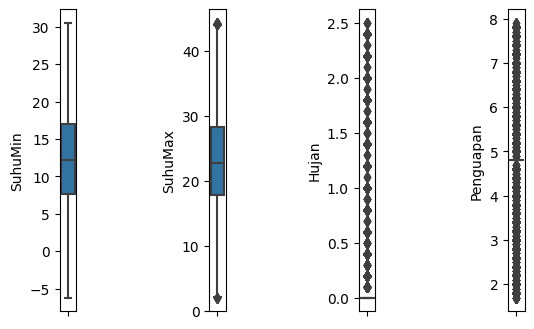

In [ ]:
mpl.rcParams['figure.dpi'] = 100
plt.figure(figsize=(5,15))
f, axes = plt.subplots(1, 4)
sns.boxplot(y=data["SuhuMin"], ax=axes[0])
sns.boxplot(y=data["SuhuMax"], ax=axes[1])
sns.boxplot(y=data["Hujan"], ax=axes[2])
sns.boxplot(y=data["Penguapan"], ax=axes[3])

plt.subplots_adjust(wspace=8)

## Scaling

**Feature Scaling**

Bertujuan untuk membuat numerical data pada dataset memiliki rentang nilai yang sama, artinya tidak ada lagi satu variabel yang mendominasi variabel data lainnya. adapun feature scalling yang akan digunakan kali ini adalah dengan minmax normalisasi.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(data)
X

array([[0.45231608, 0.31914894, 0.        , 0.5       ],
       [0.41416894, 0.35460993, 0.        , 0.14516129],
       [0.66485014, 0.70921986, 0.        , 0.5       ],
       ...,
       [0.373297  , 0.43498818, 0.64      , 0.5       ],
       [0.46321526, 0.6572104 , 0.        , 0.98387097],
       [0.50408719, 0.60047281, 0.        , 0.5       ]])

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
data_new = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])
data_new.head()

,x,y
0,0.128120,-0.080463
1,0.278456,-0.103351
2,-0.250951,-0.025469
3,0.049101,-0.091102
4,0.216239,-0.110721


In [ ]:
X = data_new.copy().values
X

array([[ 0.12812014, -0.08046284],
       [ 0.27845627, -0.10335148],
       [-0.25095109, -0.02546912],
       ...,
       [ 0.21574596,  0.53276206],
       [-0.2919761 , -0.04580387],
       [-0.08056014, -0.06138479]])

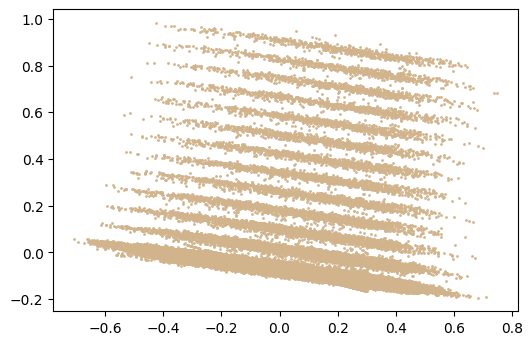

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], s=1, c='tan' )
plt.show()

PCA source : https://builtin.com/data-science/step-step-explanation-principal-component-analysis